<a href="https://colab.research.google.com/github/ean0418/ean0418/blob/main/Aug07_3_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec 이란 ?

말 그대로 Word(단어)를 to(2) Vector(벡터)로 나타내는 것

가장 널리 사용되고 있는 임베딩 방법중의 하나!!
- 임베딩(embedding) : 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자인 벡터로 나타나는 결과나 과정을 의미, 벡터가 아닌 것을 고정 길이의 벡터로 나타내는 것

특정 단어 양 옆에 있는 두 단어의 관계를 활용하기 때문에 분포가설을 잘 반영하고 있음
- 분포가설 : ' 비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가지고 있다'라는 가정을 기반하여 주변 단어 분포를 기준으로 단어의 벡터 표현이 결정되기 때문에 분산표현(Distributed Representation)

자연어 처리뿐만 아니라 추천시스템에서도 자주 사용

In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 15.3 MB/s eta 0:00:00


In [2]:
# 필요한 라이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [3]:
# 네이버 영화 리뷰 테이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")


('ratings.txt', <http.client.HTTPMessage at 0x7d9dbcc56da0>)

In [16]:
# 데이터를 데이터프레임으로 불러오가
train_data = pd.read_table('ratings.txt')

In [17]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
# 총 리뷰 갯수 확인
print(len(train_data))

200000


In [19]:
# 총 20만개의 데이터 샘플이 있음=> 결측값 유무를 확인해봐야 함!
print(train_data.isnull().values.any())

# any() : 하나라도 True인게 있으면 True
# all() : 모두 True여야 True

True


In [20]:
# 결측값이 존재하므로 결측값이 존재하는 행 제거하기

train_data = train_data.dropna(how = 'any') # 결측값이 존재하는 행 제거
# 'any' : 존재하면 제거 / 'all' : 모두 결측치면 제거

print(train_data.isnull().values.any()) # 결측값이 존재하는지 확인
# 결과로 False가 나온것이 확인됨 => 결측값이 사라졌음

False


In [13]:
# 결측값이 삭제된 후의 리뷰 갯수 확인
print(len(train_data))

199992


In [21]:
# 총 199,992개의 리뷰가 존재
# 정규 표현식을 통해 한글이 아닌 경우 내용을 없애는 전처리
# replace함수의 regex=True라는 옵션을 통해 정규 표현식을 사용했음을 알려줘야 하고,
# 공백문자 \s 까지 추가해서 띄어쓰기에 대한 내용은 처리하지 않도록 함
train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9]","")

0                                       어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1         디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                      폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3         와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                               안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
                                ...                        
199995                                       포켓 몬스터 짜가 ㅡㅡ;;
199996                                                쓰.레.기
199997                    완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
199998                  왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
199999                                      포풍저그가나가신다영차영차영차
Name: document, Length: 199992, dtype: object

In [15]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [23]:
# 불용어 제거

# 불용어 정으
stopwords =['의','가','이','은','들','는','좀','걍','과','도','를','으로',
            '자','에','와','한','하다']

okt = Okt()

tokenized_data = []
for sentence in train_data['document']:
  tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화 (stem=True : 동사의 원형)
 # 불용어 제거
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  tokenized_data.append(stopwords_removed_sentence)


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.356794271770871


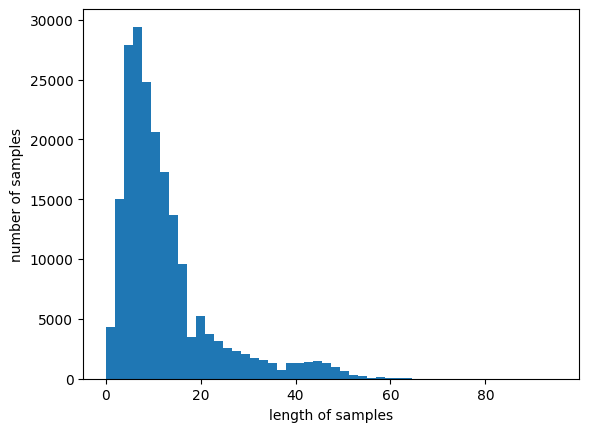

In [25]:
# 토큰화가 된 상태에서 각 리뷰의 길이 분포를 확인

print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# Word2Vec으로 토큰화 된 데이터를 학습

model = Word2Vec(sentences = tokenized_data, vector_size = 100,
                 window = 5, min_count = 5, workers = 4, sg = 0)

# 하이퍼파라미터 : 머신러닝의 모델에 대해 직접 설정할 수 있는 옵션
#   모델의 성능과 학습속도에 영향을 미침

# vector_size : 임베딩 된 벡터의 차원
# window : context window 크기, (현재 단어와 예측 단어 간의 거리)
# min_count : 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다)
# workers : 학습을 위한 프로세스 수
# sg : 알고리즘 지정 / 0 : Continuous Bag of Word(CBOW), 1 : Skip-gram
#   CBOW : 주변 단어들의 정보를 통해 중심 단어를 예측하는 방법
#   Skip-gram : 하나의 단어에서 여러 단어들을 예측하는 방법


In [29]:
# Word2Vec 임베딩 행렬의 크기 확인
model.wv.vectors.shape

(17616, 100)

In [39]:
# 총 17,616개의 단어가 존재, 각 단어는 100차원으로 구성되어 있음
# '최민식' 과 유사한 단어 찾기
# model.wv.most_similar() 함수를 통해 해당 단어와 유사하다고 판별한 단어 뽑아낼 수 있음
print(model.wv.most_similar('최민식'))

for i in model.wv.most_similar('최민식'):
  print("유사도 : " + i[0] + ",{:.2f}".format(i[1]*100))

[('송강호', 0.8182082772254944), ('한석규', 0.817758321762085), ('최민수', 0.7924011945724487), ('윤제문', 0.7916508316993713), ('이민호', 0.7894207239151001), ('박중훈', 0.7889129519462585), ('채민서', 0.7867653965950012), ('설경구', 0.7809510827064514), ('베일', 0.7787575125694275), ('안성기', 0.7767170071601868)]
유사도 : 송강호,81.82
유사도 : 한석규,81.78
유사도 : 최민수,79.24
유사도 : 윤제문,79.17
유사도 : 이민호,78.94
유사도 : 박중훈,78.89
유사도 : 채민서,78.68
유사도 : 설경구,78.10
유사도 : 베일,77.88
유사도 : 안성기,77.67


In [42]:
# '히어로'와 유사한 단어들을 뽑기
print(model.wv.most_similar('히어로'))

# wv.most_similar() 함수는 positive, negative 파라미터를 통해서
#   무협 + 정통 - 로코
#   (무협.액션이면서 로코가 아닌)
print(model.wv.most_similar(positive=['무협','정통'],negative='로코'))

[('슬래셔', 0.8434295654296875), ('sf', 0.8236619234085083), ('물', 0.8210615515708923), ('무협', 0.8170475959777832), ('호러', 0.8110142350196838), ('느와르', 0.7921784520149231), ('SF', 0.7919600009918213), ('블록버스터', 0.7873968482017517), ('블랙', 0.7849392294883728), ('무비', 0.7830307483673096)]
[('헐리우드', 0.7909543514251709), ('헐리웃', 0.7898297905921936), ('단순', 0.7884262204170227), ('첩보', 0.7719224691390991), ('애로', 0.7657152414321899), ('호러', 0.7620134949684143), ('홍콩', 0.7604166865348816), ('싸구려', 0.757493257522583), ('블록버스터', 0.748263418674469), ('물의', 0.7433258891105652)]
